# Imports

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopy
from geopy import distance
import math

import scipy
from scipy import stats
from itertools import combinations

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special
from scipy import spatial

import figurefirst as fifi
import time

from scipy import signal
import math

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import pynumdiff

In [2]:
import spatial_functions

# Read in data

In [3]:
#wind data -- download from figshare
df=pd.read_hdf('small_1.15.22_maskedgpsdata.hdf') #example data set, available from Figshare
#df=pd.read_hdf('10.20.20_all.hdf', key='/windgps')
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.time.iloc[-1]))

'2022-01-15 14:59:56'

In [4]:
#check for nan before running anything
df.isnull().values.any()

False

In [5]:
print(df.keys()) #figure out what sensors are available to compute spatial differences between 

Index(['time', 'S2_1', 'D_1', 'X_1', 'Y_1', 'Z_1', 'S2_2', 'D_2', 'X_2', 'Y_2',
       'Z_2', 'S2_3', 'D_3', 'X_3', 'Y_3', 'Z_3', 'S2_4', 'D_4', 'X_4', 'Y_4',
       'Z_4', 'S2_5', 'D_5', 'X_5', 'Y_5', 'Z_5', 'S2_6', 'D_6', 'X_6', 'Y_6',
       'Z_6', 'S2_7', 'D_7', 'X_7', 'Y_7', 'Z_7', 'S2_8_verticallyorientated',
       'D_8_verticallyorientated', 'X_8_verticallyorientated',
       'Y_8_verticallyorientated', 'Z_8_verticallyorientated',
       'S2_9_verticallyorientated', 'D_9_verticallyorientated',
       'X_9_verticallyorientated', 'Y_9_verticallyorientated',
       'Z_9_verticallyorientated', 'U_8_verticallyorientated',
       'V_8_verticallyorientated', 'U_9_verticallyorientated',
       'V_9_verticallyorientated'],
      dtype='object')


In [6]:

df_dir=df[['D_1', 'D_2', 'D_3','D_4', 'D_5', 'D_6', 'D_7' ]]
df_speeds=df[['S2_1', 'S2_2', 'S2_3', 'S2_4', 'S2_5','S2_6', 'S2_7', ]]
df_x=df[['X_1', 'X_2', 'X_3','X_4', 'X_5', 'X_6', 'X_7', ]]
df_y=df[['Y_1', 'Y_2', 'Y_3','Y_4', 'Y_5','Y_6', 'Y_7',]]
df_z=df[['Z_1', 'Z_2', 'Z_3','Z_4', 'Z_5','Z_6', 'Z_7', ]]


In [7]:
#calculate the difference in direction, difference in speed, avg direction, and avg speed between each pair of sensors at all points in time series
direction_diff, direction_avg, speed_diff, speed_avg = spatial_functions.spatialchanges(df_dir, df_speeds, df_x, df_y, df_z)
# find the 10 min averages 
direction_diff_10min, direction_avg_10min, speed_diff_10min, speed_avg_10min = spatial_functions.find_avg_values(direction_diff, direction_avg, speed_diff, speed_avg)

In [8]:
#control data from the same date/time as our wind data - WRCC managed tower (https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?nvsagh);
control_station_data=pd.read_excel('WRCC tower data/1.15.22_WRCC.xls',  names=['Date time',  'Mean Wind Speed', 'Wind Vector Magnitude', 'Mean Wind Direction', 'Std Deviation of Wind Direction', 'Mean Wind Speed 100ft', 'Wind Vector Speed 100ft', 'Wind Direction 100ft', 'Std Dev of Wind Direction 100ft' ])
control_station_data

Date time  Mean Wind Speed  Wind Vector Magnitude  Mean Wind Direction  \
0   2201151150            0.959                  0.858                85.80   
1   2201151200            1.271                  1.210                91.20   
2   2201151210            1.579                  1.490                92.60   
3   2201151220            1.478                  1.438                97.50   
4   2201151230            1.307                  1.149                80.70   
5   2201151240            1.540                  1.466                90.20   
6   2201151250            1.370                  1.280                85.20   
7   2201151300            1.446                  1.369                89.30   
8   2201151310            1.173                  1.032                85.50   
9   2201151320            1.404                  1.281                82.30   
10  2201151330            1.112                  0.983                88.70   
11  2201151340            0.911                  0.821                90.30   
12  2201151350            0.907                  0.835                89.40   
13  2201151400            0.872                  0.836                86.10   
14  2201151410            0.995                  0.947                89.10   
15  2201151420            0.813                  0.714                78.81   
16  2201151430            0.675                  0.555                75.24   
17  2201151440            0.543                  0.476                82.50   
18  2201151450            0.622                  0.604                93.20   

    Std Deviation of Wind Direction  Mean Wind Speed 100ft  \
0                             26.13                  1.916   
1                             17.74                  1.673   
2                             19.32                  2.041   
3                             13.26                  1.768   
4                             28.19                  2.784   
5                             17.75                  2.630   
6                             20.76                  2.576   
7                             18.68                  2.422   
8                             28.10                  2.088   
9                             23.97                  2.484   
10                            27.62                  2.283   
11                            25.53                  1.934   
12                            22.81                  1.802   
13                            16.35                  1.919   
14                            17.73                  2.134   
15                            27.13                  1.818   
16                            33.85                  1.553   
17                            27.78                  1.751   
18                            13.90                  1.788   

    Wind Vector Speed 100ft  Wind Direction 100ft  \
0                     1.820                 64.68   
1                     1.577                 59.80   
2                     1.949                 67.68   
3                     1.725                 75.82   
4                     2.729                 62.89   
5                     2.564                 66.24   
6                     2.539                 64.25   
7                     2.365                 58.18   
8                     1.964                 59.93   
9                     2.425                 63.59   
10                    2.206                 62.51   
11                    1.866                 59.38   
12                    1.765                 60.47   
13                    1.856                 61.81   
14                    2.092                 58.48   
15                    1.739                 61.50   
16                    1.501                 52.78   
17                    1.708                 54.93   
18                    1.717                 61.91   

    Std Dev of Wind Direction 100ft  
0                             18.14  
1                             19.40  
2       

In [9]:
print(len(control_station_data),len(direction_diff_10min.columns))

19 19


# Spatial Analysis

In [10]:
## filtering the data at 2 different cutoffs
#sos_light = signal.butter(2, 2,  'lp', fs=10, output='sos')
#sos_mod = signal.butter(2, .5,  'lp', fs=10, output='sos')
#sos_mod = signal.butter(2, .2,  'lp', fs=10, output='sos')
filtereddir_light, filteredspeed_light =spatial_functions.smoothdf_pynum(df_dir, df_speeds, dt=.1, params=[3,.5,10], unwrap=True)
filtereddir_mod, filteredspeed_mod =spatial_functions.smoothdf_pynum(df_dir, df_speeds, dt=.1, params=[3,.1,10], unwrap=True)


In [12]:
## calculating averages and differences for smoothed data 

#calculate the difference in direction, difference in speed, avg direction, and avg speed between each pair of sensors at all points in time series
smooth_light_direction_diff, smooth_light_direction_avg, smooth_light_speed_diff, smooth_light_speed_avg = spatial_functions.spatialchanges(filtereddir_light,  filteredspeed_light, df_x, df_y, df_z)
# find the 10 min averages 
smooth_light_direction_diff_10min, smooth_light_direction_avg_10min, smooth_light_speed_diff_10min, smooth_light_speed_avg_10min = spatial_functions.find_avg_values(smooth_light_direction_diff, smooth_light_direction_avg, smooth_light_speed_diff, smooth_light_speed_avg)



#calculate the difference in direction, difference in speed, avg direction, and avg speed between each pair of sensors at all points in time series
smooth_mod_direction_diff, smooth_mod_direction_avg, smooth_mod_speed_diff, smooth_mod_speed_avg = spatial_functions.spatialchanges(filtereddir_mod,  filteredspeed_mod, df_x, df_y, df_z)
# find the 10 min averages 
smooth_mod_direction_diff_10min, smooth_mod_direction_avg_10min, smooth_mod_speed_diff_10min, smooth_mod_speed_avg_10min = spatial_functions.find_avg_values(smooth_mod_direction_diff, smooth_mod_direction_avg, smooth_mod_speed_diff, smooth_mod_speed_avg)


In [13]:
# should produce a df with # of rows = NxM of 10 min avg dfs 
reorg_ddf=pd.DataFrame(columns = ['distance','speed_avg', 'direction_avg', 'direction_diff', 'speed_diff', 'smooth_mod_speed_diff', 'smooth_mod_speed_avg', 'smooth_mod_direction_avg', 'smooth_mod_direction_diff',  'smooth_light_speed_avg', 'smooth_light_direction_avg', 'smooth_light_direction_diff', 'smooth_light_speed_diff', 'control_D_100', 'control_S2_100'])
i=0
for k in direction_avg_10min.index:
    xtra = {'distance': k,
           'direction_avg': direction_avg_10min.iloc[i,:],
            'direction_diff': direction_diff_10min.iloc[i,:],
            'speed_avg': speed_avg_10min.iloc[i,:],
            'speed_diff': speed_diff_10min.iloc[i,:],
            
            'smooth_light_direction_avg': smooth_light_direction_avg_10min.iloc[i,:],
            'smooth_light_direction_diff': smooth_light_direction_diff_10min.iloc[i,:],
            'smooth_light_speed_avg': smooth_light_speed_avg_10min.iloc[i,:],
            'smooth_light_speed_diff': smooth_light_speed_diff_10min.iloc[i,:],

            'smooth_mod_direction_avg': smooth_mod_direction_avg_10min.iloc[i,:],
            'smooth_mod_direction_diff': smooth_mod_direction_diff_10min.iloc[i,:],
            'smooth_mod_speed_avg': smooth_mod_speed_avg_10min.iloc[i,:],
            'smooth_mod_speed_diff': smooth_mod_speed_diff_10min.iloc[i,:],
            
            'control_S2_100': control_station_data['Mean Wind Speed 100ft'],
            'control_D_100': control_station_data['Std Dev of Wind Direction 100ft'],
           }
    reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
    i=i+1

/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_62006/3559536175.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_62006/3559536175.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_62006/3559536175.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reorg_ddf= reorg_ddf.append(pd.DataFrame(xtra))
/var/folders/0c/q32x1j5s1zqg0747td81nt840000gn/T/ipykernel_62006/3559536175.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [14]:
#reorg_ddf.speed=reorg_ddf.index #give avg speed its own column
reorg_ddf.reset_index(inplace=True)
#rename index to environment and assign column value based on environment
reorg_ddf.rename(columns={'index':'environment'}, inplace=True)
reorg_ddf[['environment']]=.04 # [.001 - Black Rock, .04 - Lemmon Valley, .4 - Tahoe Forest, 1 - Urban]
reorg_ddf[['group']]=8 # ordered from 1-16 based on date of collection
reorg_ddf

environment  distance  speed_avg  direction_avg  direction_diff  \
0           0.04     10.73   1.202125     142.103012       52.027167   
1           0.04     10.73   1.315746     125.733902       46.294167   
2           0.04     10.73   0.979399      22.677606       46.282167   
3           0.04     10.73   1.151459     332.842158       41.893833   
4           0.04     10.73   1.148266     165.411422       60.222500   
..           ...       ...        ...            ...             ...   
394         0.04    134.54   1.092684     159.628827       67.470833   
395         0.04    134.54   0.887913     152.616772       79.679833   
396         0.04    134.54   1.074578     169.378223       63.360333   
397         0.04    134.54   0.905683     161.606205       45.412167   
398         0.04    134.54   1.048107     148.721611       52.373333   

     speed_diff  smooth_mod_speed_diff  smooth_mod_speed_avg  \
0     -0.250189              -0.250027              1.202097   
1     -0.110542              -0.110522              1.315850   
2     -0.053816              -0.053823              0.979251   
3      0.117602               0.117570              1.151424   
4     -0.330045              -0.329935              1.148280   
..          ...                    ...                   ...   
394    0.415785               0.415704              1.092699   
395    0.138727               0.138858              0.887882   
396    0.354220               0.354203              1.074568   
397    0.282579               0.282535              0.905688   
398    0.176974               0.176915              1.048119   

     smooth_mod_direction_avg  smooth_mod_direction_diff  \
0                  141.280379                  51.059336   
1                  126.131544                  42.583773   
2                   22.748404                  41.313587   
3                  331.915218                  38.183762   
4                  166.051613                  58.469852   
..                        ...                        ...   
394                160.094299                  64.657533   
395                154.939816                  78.255308   
396                169.925210                  61.304907   
397                161.647913                  38.858309   
398                148.620600                  50.013606   

     smooth_light_speed_avg  smooth_light_direction_avg  \
0                  1.202129                  141.914874   
1                  1.315736                  125.652434   
2                  0.979409                   22.409783   
3                  1.151471                  332.567116   
4                  1.148256                  165.630432   
..                      ...                         ...   
394                1.092665                  159.597465   
395                0.887940                  153.620833   
396                1.074572                  169.489099   
397                0.905679                  161.529835   
398                1.048108                  148.625896   

     smooth_light_direction_diff  smooth_light_speed_diff  control_D_100  \
0                      50.766183                -0.250192          18.14   
1                      44.907583                -0.110565          19.40   
2                      44.518111                -0.053793          17.24   
3                      40.348619                 0.117594          12.62   
4                      59.335371                -0.330030          11.37   
..                           ...                      ...            ...   
394                    66.440603                 0.415777          11.35   
395                    79.135391                 0.138763          16.85   
396                    62.699909                 0.354211          14.82   
397                    42.285314                 0.282573          12.82   
398                    51.645435                 0.176986          16.17   

     control_S2_100  group  

In [15]:
reorg_ddf['speed_diff_abs']=np.abs(reorg_ddf.speed_diff)
reorg_ddf['smooth_light_speed_diff_abs']=np.abs(reorg_ddf.smooth_light_speed_diff)
reorg_ddf['smooth_mod_speed_diff_abs']=np.abs(reorg_ddf.smooth_mod_speed_diff)

In [16]:
#save to HDF file
reorg_ddf.to_hdf('1.15.22_spatial.hdf', key='/windgps')

## Comparing smoothed vs unsmoothed data 

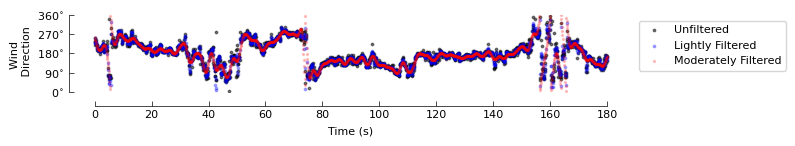

In [17]:
mpl.rcParams.update({'font.size': 8})
fig,ax = plt.subplots(figsize=(8,1.5), layout='tight')

time=np.linspace(0,180, 1800)

#ax.set_title('Signal smoothing')

ax.set_ylabel('Wind \n Direction')
ax.set_xlabel('Time (s)')
ax.scatter(time, df_dir.D_4.iloc[0:1800], s=3, alpha=.5, label='Unfiltered', color='black', rasterized=True)
ax.scatter(time, filtereddir_light.D_4.iloc[0:1800], s=3, alpha=.3, label='Lightly Filtered', color='blue', rasterized=True)
ax.scatter(time, filtereddir_mod.D_4.iloc[0:1800], s=2, alpha=.2, label='Moderately Filtered', color='red', rasterized=True)
ax.set_ylim(0,360)
ax.legend(bbox_to_anchor=(1,1))

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],
                                yticks=[0,90,180,270,360],
                                 xticks=np.arange(0,200,20),
                                 tick_length=3.5,
                                 spine_locations={'left': 0, 'bottom': 10},
                                 linewidth=.5)



evenyticks=np.arange(0, 360+90, 90)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax.set_yticklabels(yticklabels)
fig.savefig('small_snippet_figure2a.svg', dpi=1200, format='svg')

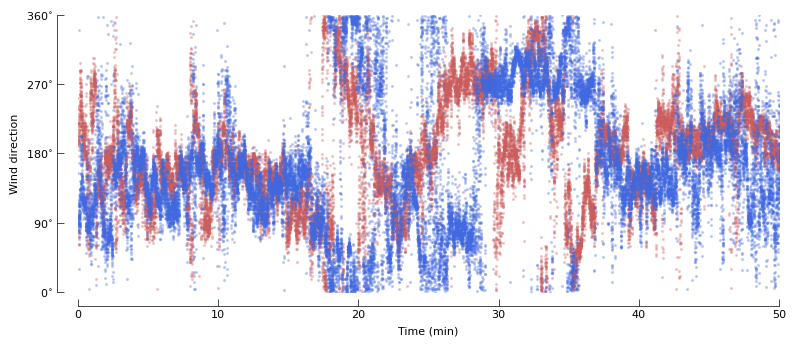

In [18]:
fig,ax = plt.subplots(figsize=(8,3.5), layout='tight')

time=np.linspace(0,len(df)/600,len(df))

ax.scatter(time, df_dir.D_4, s=7, alpha=.25,marker='.', linewidth=None, color='indianred', label='Sensor D', rasterized=True)
#ax.axvspan(xmin=0, xmax=3, color='slategrey', alpha=.3)
ax.scatter(time, df_dir.D_6, s=7, alpha=.25,marker='.', linewidth=None, color='royalblue', label='Sensor F', rasterized=True)
ax.set_ylim(0,360)
ax.set_xlim(0,50)


#ax.set_title('Two moderately filtered signals')
ax.set_ylabel('Wind direction')
ax.set_xlabel('Time (min)')
#ax.legend(bbox_to_anchor=(1,1))


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],
                                yticks=[0,90,180,270,360],
                                 xticks=np.arange(0,60,10),
                                 tick_length=5,
                                 spine_locations={'left': 15, 'bottom': 10},
                                 linewidth=.5)


evenyticks=np.arange(0, 360+90, 90)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax.set_yticklabels(yticklabels)


#ax.axis("off")

fig.savefig('unfilteredsignals_fig2a.svg', dpi=600, format='svg')

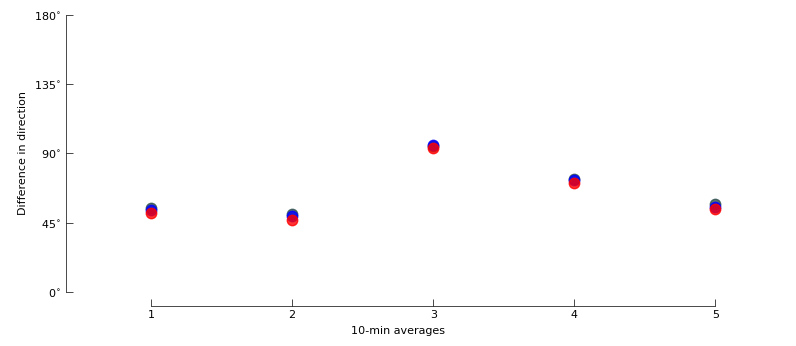

In [21]:
u=np.array([df.X_4.iloc[0],df.Y_4.iloc[0],df.Z_4.iloc[0]]) #sensor1
v=np.array([df.X_6.iloc[0],df.Y_6.iloc[0],df.Z_6.iloc[0]]) #sensor2
distance= scipy.spatial.distance.euclidean(u,v)*1000 #distance between sensor1 and sensor2 in meters
achunk = reorg_ddf[reorg_ddf.distance==np.round(distance,2)]

fig,ax= plt.subplots(figsize=(8,3.5), layout='tight')
t=np.arange(1, len(achunk)+1)
ax.plot(t, achunk.direction_diff, '.', markersize=15, alpha=.8, color='darkslategrey', label='unfiltered')
ax.plot(t, achunk.smooth_light_direction_diff, '.', markersize=15, alpha=.8, color='blue', label='lightly filtered')
ax.plot(t, achunk.smooth_mod_direction_diff, '.', markersize=15, alpha=.8, color='red', label='moderately filtered')
ax.set_ylim(0,180)
ax.set_xlim(0,5.5)


ax.set_ylabel('Difference in direction')
ax.set_xlabel('10-min averages')
#ax.legend(bbox_to_anchor=(1,1))


fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],
                                yticks=[0,45, 90, 135, 180],
                                 xticks=np.arange(1,6,1),
                                 tick_length=5,
                                 spine_locations={'left': -40, 'bottom': 10},
                                 linewidth=.5)


evenyticks=np.arange(0, 180+45, 45)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax.set_yticklabels(yticklabels)

fig.savefig('differencedsensors_fig2a.svg', dpi=1200, format='svg')

## Visualizing all the data

In [22]:
df1=pd.read_hdf('dfs_for_spatialregression/10.20.20_spatial.hdf')
df2=pd.read_hdf('dfs_for_spatialregression/7.7.21_spatial.hdf')
df3=pd.read_hdf('dfs_for_spatialregression/9.26.21_spatial.hdf')
df4=pd.read_hdf('dfs_for_spatialregression/10.29.21_spatial.hdf')
df5=pd.read_hdf('dfs_for_spatialregression/10.30.21_spatial.hdf')
df6=pd.read_hdf('dfs_for_spatialregression/1.8.22_spatial.hdf')
df7=pd.read_hdf('dfs_for_spatialregression/1.11.22_spatial.hdf')
df8=pd.read_hdf('dfs_for_spatialregression/1.15.22_spatial.hdf')
df9=pd.read_hdf('dfs_for_spatialregression/4.30.22_spatial.hdf')
df10=pd.read_hdf('dfs_for_spatialregression/5.1.22_spatial.hdf')
df11=pd.read_hdf('dfs_for_spatialregression/5.2.22_spatial.hdf')
df12=pd.read_hdf('dfs_for_spatialregression/6.1.22_spatial.hdf')
df13=pd.read_hdf('dfs_for_spatialregression/6.3.22_spatial.hdf')
df14=pd.read_hdf('dfs_for_spatialregression/6.7.22_spatial.hdf')
df15=pd.read_hdf('dfs_for_spatialregression/6.8.22_spatial.hdf')
df16=pd.read_hdf('dfs_for_spatialregression/6.22.22_spatial.hdf')
df1

environment  distance  speed_avg  direction_avg  direction_diff  \
0          0.001     24.70   1.163327     107.484953       31.175500   
1          0.001     24.70   1.171273     141.527988       30.140833   
2          0.001     24.70   1.268499     158.784232       22.348833   
3          0.001     24.70   1.369022     158.640165       27.384667   
4          0.001     24.70   1.280953     177.552617       33.739667   
..           ...       ...        ...            ...             ...   
555        0.001     94.05   4.984498     205.540113        5.844500   
556        0.001     94.05   4.618164     202.926146        5.876667   
557        0.001     94.05   5.150205     206.196001        4.783500   
558        0.001     94.05   5.431272     205.256679        4.012833   
559        0.001     94.05   4.887982     204.816974        5.577000   

     speed_diff  smooth_mod_speed_diff  smooth_mod_speed_avg  \
0     -0.110293              -0.110047              1.163639   
1      0.049150               0.048879              1.171097   
2     -0.007908              -0.007735              1.268954   
3      0.244372               0.244532              1.368487   
4      0.243475               0.243309              1.281008   
..          ...                    ...                   ...   
555    0.510947               0.510608              4.984827   
556    0.637965               0.637691              4.618078   
557    0.786037               0.787061              5.149795   
558    0.511593               0.511544              5.431174   
559    0.391757               0.391509              4.887826   

     smooth_mod_direction_avg  smooth_mod_direction_diff  \
0                  107.492079                  29.665497   
1                  141.522013                  26.582737   
2                  158.492891                  19.034976   
3                  158.524047                  24.155244   
4                  177.231886                  30.987010   
..                        ...                        ...   
555                205.540665                   4.794447   
556                202.926482                   5.071377   
557                206.189531                   3.769182   
558                205.259597                   2.992589   
559                204.816177                   4.688201   

     smooth_light_speed_avg  smooth_light_direction_avg  \
0                  1.163330                  107.478579   
1                  1.171270                  141.454182   
2                  1.268506                  158.810346   
3                  1.369015                  158.617340   
4                  1.280954                  177.450389   
..                      ...                         ...   
555                4.984494                  205.539612   
556                4.618157                  202.926224   
557                5.150221                  206.195562   
558                5.431266                  205.256615   
559                4.887967                  204.816870   

     smooth_light_direction_diff  smooth_light_speed_diff  control_D_100  \
0                      30.424092                -0.110284          35.77   
1                      28.542249                 0.049145          18.84   
2                      20.986687                -0.007905          21.28   
3                      26.046020                 0.244360          24.45   
4                      32.449060                 0.243484          30.68   
..                           ...                      ...            ...   
555                     5.449069                 0.510910          35.97   
556                     5.511393                 0.637934          45.82   
557                     4.373762                 0.786042          39.60   
558                     3.610560                 0.511607          49.58   
559                     5.220217                 0.391750          41.46   

     control_S2_100  group  

In [23]:
desertchunks=pd.concat([df1, df7,df8,df12,df13])
forestchunks=pd.concat([df2,df4,df14,df15,df16])
urbanchunks=pd.concat([df3,df5,df6,df9,df10,df11])
allchunks=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]
alldf=pd.concat(allchunks)
desert=0,6,7,11,12
forest=1,3,13,14,15
urban=2,4,5,8,9,10

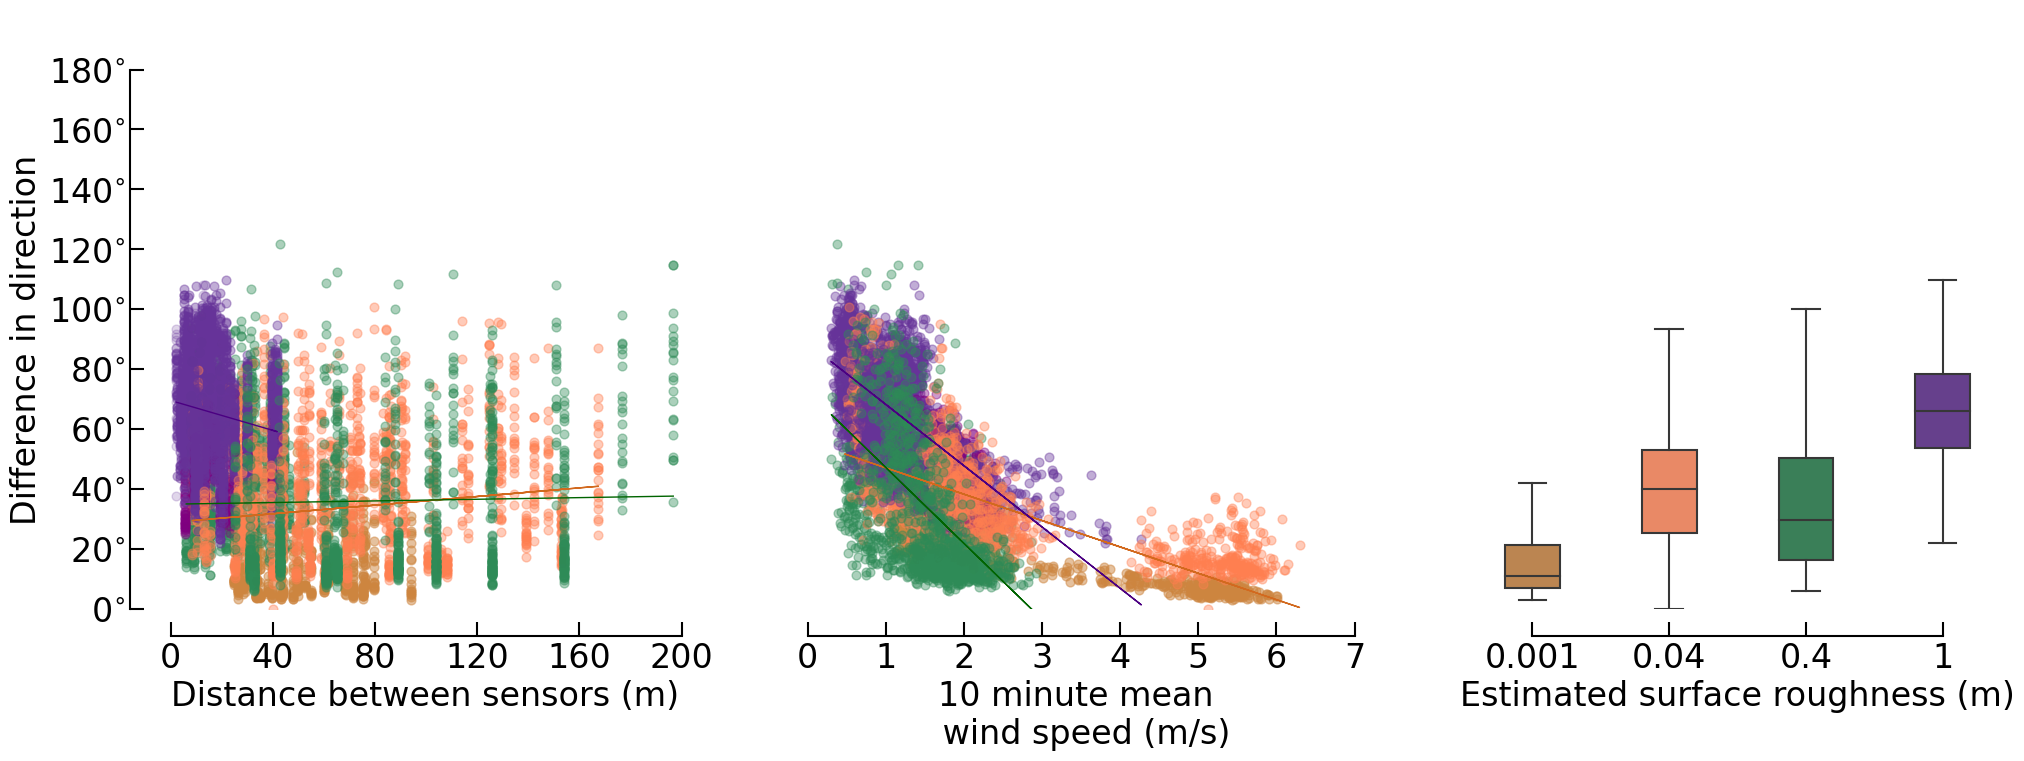

In [24]:
mpl.rcParams.update({'font.size': 24})
allchunks=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]
c=['peru', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7))

ax[0].scatter(allchunks[0].distance, allchunks[0].smooth_mod_direction_diff, s=40, color=c[0], alpha=.5, label='desert/valley')
ax[1].scatter(allchunks[0].speed_avg, allchunks[0].smooth_mod_direction_diff,  s=40, color=c[0], alpha=.5, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].smooth_mod_direction_diff, s=40, color=c[1], alpha=.4, label='forest')
ax[1].scatter(allchunks[1].speed_avg, allchunks[1].smooth_mod_direction_diff,  s=40, color=c[1], alpha=.4, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].smooth_mod_direction_diff, s=40, color=c[2], alpha=.2, label='urban')
ax[1].scatter(allchunks[2].speed_avg, allchunks[2].smooth_mod_direction_diff,  s=40, color=c[2], alpha=.4, label='urban')

# add mean lines
slope, intercept = np.polyfit(desertchunks.distance, desertchunks.smooth_mod_direction_diff, 1)
abline_values = [slope * i + intercept for i in desertchunks.distance]
ax[0].plot(desertchunks.distance, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.distance, forestchunks.smooth_mod_direction_diff, 1)
abline_values = [slope * i + intercept for i in forestchunks.distance]
ax[0].plot(forestchunks.distance, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.distance, urbanchunks.smooth_mod_direction_diff, 1)
abline_values = [slope * i + intercept for i in urbanchunks.distance]
ax[0].plot(urbanchunks.distance, abline_values, 'indigo', linewidth=1)


slope, intercept = np.polyfit(desertchunks.smooth_mod_speed_avg, desertchunks.smooth_mod_direction_diff, 1)
abline_values = [slope * i + intercept for i in desertchunks.smooth_mod_speed_avg]
ax[1].plot(desertchunks.smooth_mod_speed_avg, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.smooth_mod_speed_avg, forestchunks.smooth_mod_direction_diff, 1)
abline_values = [slope * i + intercept for i in forestchunks.smooth_mod_speed_avg]
ax[1].plot(forestchunks.smooth_mod_speed_avg, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.smooth_mod_speed_avg, urbanchunks.smooth_mod_direction_diff, 1)
abline_values = [slope * i + intercept for i in urbanchunks.smooth_mod_speed_avg]
ax[1].plot(urbanchunks.smooth_mod_speed_avg, abline_values, 'indigo', linewidth=1)

for i in range(3,16):
    ax[0].scatter(allchunks[i].distance, allchunks[i].smooth_mod_direction_diff, s=40, color=c[i], alpha=.4)
    ax[1].scatter(allchunks[i].smooth_mod_speed_avg, allchunks[i].smooth_mod_direction_diff,  s=40, color=c[i], alpha=.4)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.smooth_mod_direction_diff, showfliers=False, palette=['peru','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[2].set_xticklabels([.001,.04, .4, 1])
ax[0].set_ylim(0,180)
ax[1].set_ylim(0,180) 
ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,3.5) 
#ax[0].set_xlim(0,100)
ax[0].set_ylabel('Difference in direction')
ax[0].set_xlabel('Distance between sensors (m)')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute mean \n wind speed (m/s)')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness (m)')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

#ax[0].legend(bbox_to_anchor=(1,1))
#ax[1].legend(bbox_to_anchor=(1,1))
#ax[2].legend(bbox_to_anchor=(1,1))



fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=[0,20,40,60,80,100,120,140,160,180],
                                 xticks=[0,40,80,120,160, 200],
                                 tick_length=10,
                                 spine_locations={'left': 15, 'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,1,2,3,4, 5,6,7],
                                 tick_length=10,
                                 spine_locations={'bottom':20},
                                 linewidth=1.5)


# set yticklabels
#evenyticks = np.arange(0, 180+20, 20)
#yticklabels = [['$' + str(y) + '^{\circ}$', ''] for y in evenyticks]
#yticklabels = np.ravel(yticklabels)[0:-1]
#ax[0].set_yticklabels(yticklabels)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 
                                 tick_length=10,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)





evenyticks=np.arange(0, 200, 20)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax[0].set_yticklabels(yticklabels)
fig.savefig('figure2b.svg', bbox_inches='tight', dpi=600, format='svg')

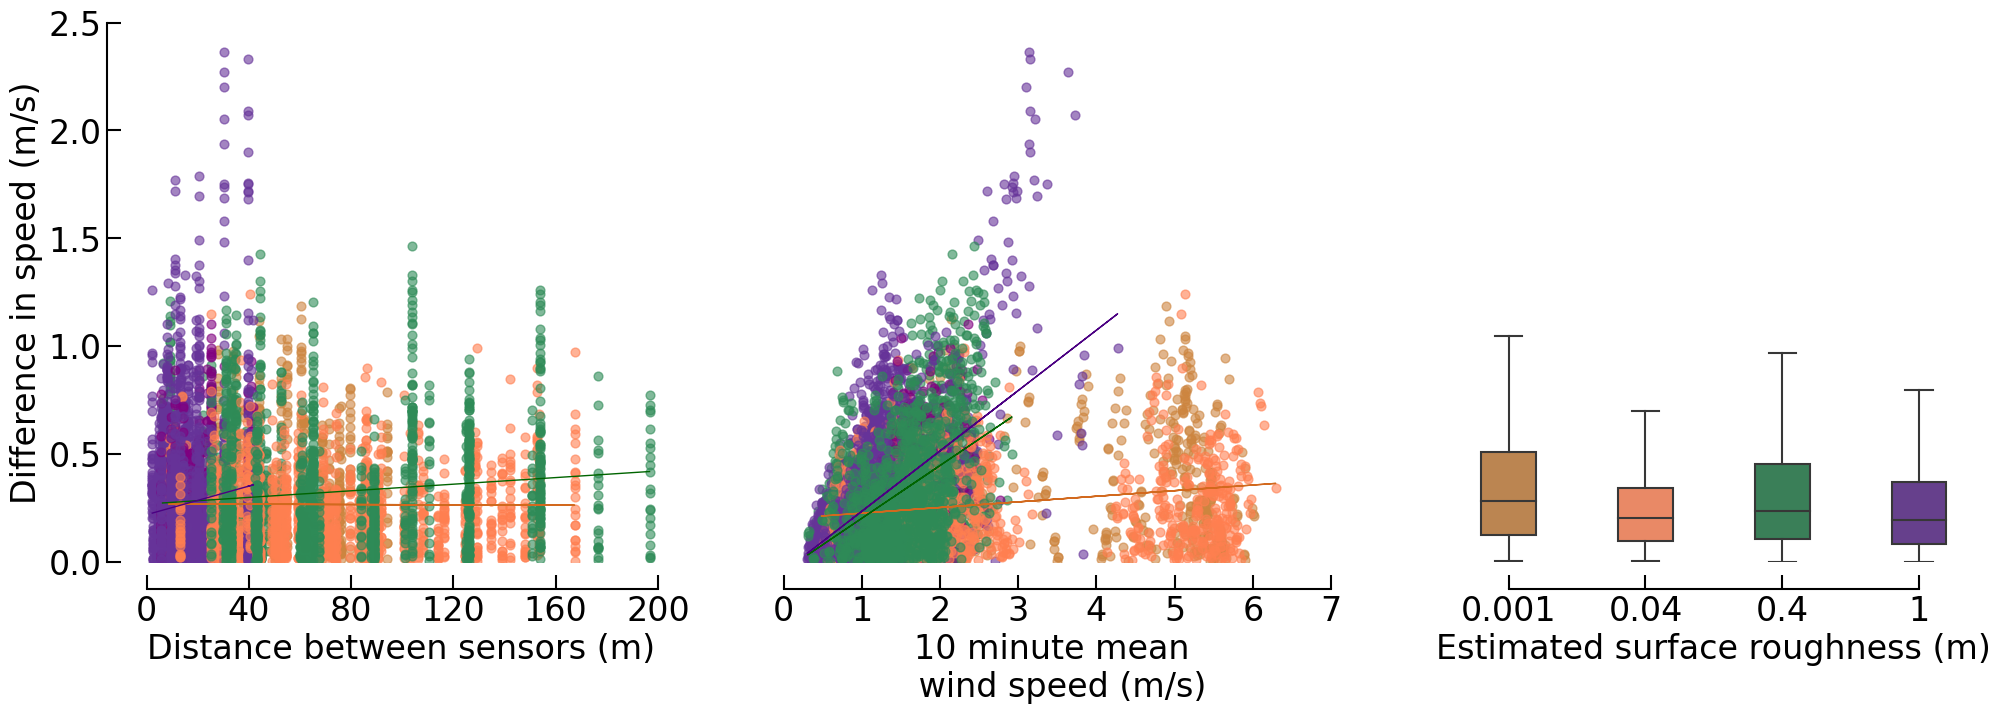

In [25]:
mpl.rcParams.update({'font.size': 24})

c=['peru', 'seagreen', 'rebeccapurple', 'seagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'purple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'seagreen', 'seagreen', 'seagreen']

fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(24,7), rasterized=True)

ax[0].scatter(allchunks[0].distance, allchunks[0].smooth_mod_speed_diff_abs, s=40, color=c[0], alpha=.6, label='desert/valley')
ax[0].scatter(allchunks[1].distance, allchunks[1].smooth_mod_speed_diff_abs, s=40, color=c[1], alpha=.6, label='forest')
ax[0].scatter(allchunks[2].distance, allchunks[2].smooth_mod_speed_diff_abs, s=40, color=c[2], alpha=.6, label='urban')

ax[1].scatter(allchunks[0].speed_avg, allchunks[0].smooth_mod_speed_diff_abs,  s=40, color=c[0], alpha=.6, label='desert/valley')
ax[1].scatter(allchunks[1].speed_avg, allchunks[1].smooth_mod_speed_diff_abs,  s=40, color=c[1], alpha=.6, label='forest')
ax[1].scatter(allchunks[2].speed_avg, allchunks[2].smooth_mod_speed_diff_abs,  s=40, color=c[2], alpha=.6, label='urban')


# add mean lines
slope, intercept = np.polyfit(desertchunks.distance, desertchunks.smooth_mod_speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in desertchunks.distance]
ax[0].plot(desertchunks.distance, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.distance, forestchunks.smooth_mod_speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in forestchunks.distance]
ax[0].plot(forestchunks.distance, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.distance, urbanchunks.smooth_mod_speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in urbanchunks.distance]
ax[0].plot(urbanchunks.distance, abline_values, 'indigo', linewidth=1)


slope, intercept = np.polyfit(desertchunks.smooth_mod_speed_avg, desertchunks.smooth_mod_speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in desertchunks.smooth_mod_speed_avg]
ax[1].plot(desertchunks.smooth_mod_speed_avg, abline_values, 'chocolate', linewidth=1)
slope, intercept = np.polyfit(forestchunks.smooth_mod_speed_avg, forestchunks.smooth_mod_speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in forestchunks.smooth_mod_speed_avg]
ax[1].plot(forestchunks.smooth_mod_speed_avg, abline_values, 'darkgreen',linewidth=1)
slope, intercept = np.polyfit(urbanchunks.smooth_mod_speed_avg, urbanchunks.smooth_mod_speed_diff_abs, 1)
abline_values = [slope * i + intercept for i in urbanchunks.smooth_mod_speed_avg]
ax[1].plot(urbanchunks.smooth_mod_speed_avg, abline_values, 'indigo', linewidth=1)



for i in range(3,16):
    ax[0].scatter(allchunks[i].distance,  allchunks[i].smooth_mod_speed_diff_abs, s=40, color=c[i], alpha=.6)
    ax[1].scatter(allchunks[i].smooth_mod_speed_avg, allchunks[i].smooth_mod_speed_diff_abs,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].direction_avg, allchunks[i].speed_diff,  s=40, color=c[i], alpha=.6)
    #ax[2].scatter(allchunks[i].environment, allchunks[i].direction,  s=20, color=c[i], alpha=.6)

    
sns.boxplot(x=alldf.environment, y=alldf.smooth_mod_speed_diff_abs, showfliers=False, palette=['peru','coral', 'seagreen', 'rebeccapurple',], width=.4, ax=ax[2])
ax[2].set_xticklabels([.001,.04, .4, 1])
#ax[1].set_ylim(0,180) 
#ax[2].set_ylim(0,180) 
#ax[1].set_xlim(0,360) 
ax[0].set_ylim(0,2.5)
ax[1].set_ylim(0,2.5)
ax[2].set_ylim(0,2.5)
ax[0].set_ylabel('Difference in speed (m/s)')
ax[0].set_xlabel('Distance between sensors (m)')  
#ax[1].set_ylabel('Change in direction, degrees')
ax[1].set_xlabel('10 minute mean \n wind speed (m/s)')
#ax[2].set_xlabel('cos(10 minute average direction)')
ax[2].set_ylabel('')
ax[2].set_xlabel('Estimated surface roughness (m)')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)


# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')

#ax[0].legend(bbox_to_anchor=(1,1))
#ax[1].legend(bbox_to_anchor=(.78,1))
#ax[2].legend(bbox_to_anchor=(1,1))





fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                yticks=[0,0.5,1.0,1.5,2.0,2.5],
                                 xticks=[0,40,80,120,160, 200],
                                 tick_length=10,
                                 spine_locations={'left': 15, 'bottom': 20},
                                 linewidth=1.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 xticks=[0,1,2,3,4, 5,6,7],
                                 tick_length=10,
                                 spine_locations={'bottom':20},
                                 linewidth=1.5)

fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 
                                 tick_length=10,
                                 spine_locations={ 'bottom': 20},
                                 linewidth=1.5)




fig.savefig('figure2c.svg', bbox_inches='tight', dpi=600, format='svg')

# Regression analysis

In [26]:
all_df=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]

In [27]:
alldf=pd.concat(all_df)

In [28]:
#normalize pandas columns
N=len(alldf)+1
normalized_data = alldf.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))


## Direction

In [29]:
df=alldf
#normalize pandas columns
N=len(df)+1
normalized_data = df.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))

mod = smf.ols(formula='direction_diff ~ speed_avg*environment + distance*environment + environment*control_D_100', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': df.group})
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         direction_diff   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     42.30
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           9.29e-09
Time:                        11:14:05   Log-Likelihood:                -6347.5
No. Observations:                7244   AIC:                         1.271e+04
Df Residuals:                    7236   BIC:                         1.277e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

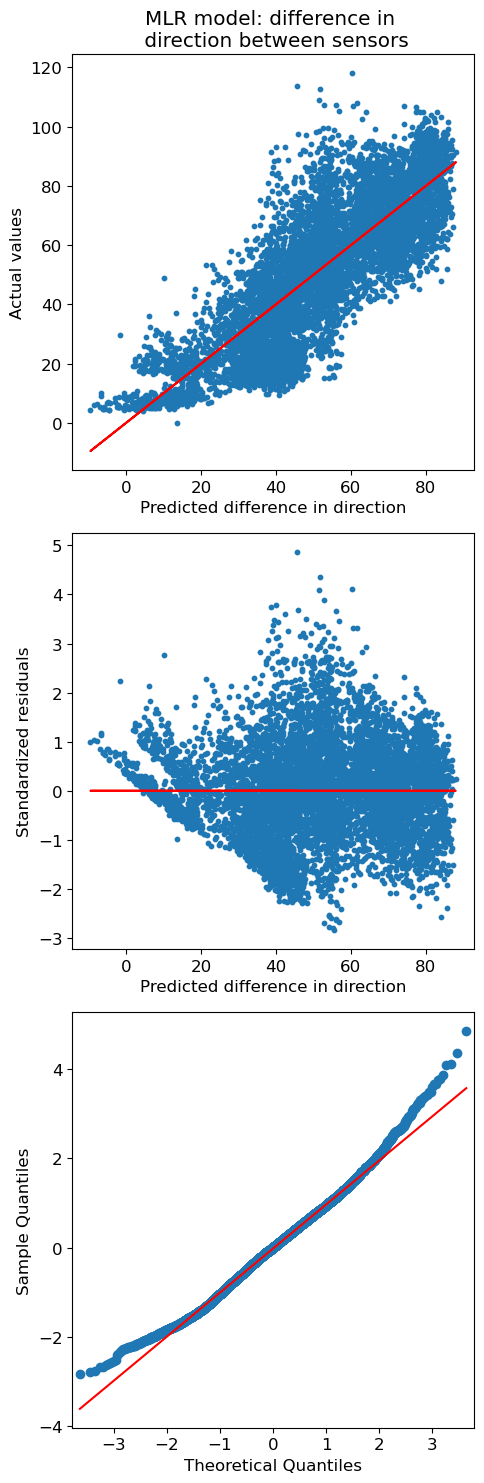

In [30]:
#using non-normalized data for residual plots
mod = smf.gls(formula='direction_diff ~ speed_avg*environment + distance*environment + environment*control_D_100', data=alldf)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
#print(res.summary())


mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight')

slope, intercept = np.polyfit(res.fittedvalues, alldf.direction_diff, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: difference in \n direction between sensors')
ax[0].scatter(res.fittedvalues, alldf.direction_diff, s=10, rasterized=True)
ax[0].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[0].set_xlabel ('Predicted difference in direction')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10, rasterized=True)
ax[1].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[1].set_xlabel ('Predicted difference in direction')
ax[1].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', ax=ax[2], rasterized=True)

plt.show()

fig.savefig('residualplots_direction_spatial_S5a.svg', dpi=600, format='svg')

## Speed

In [31]:
mod = smf.ols(formula='speed_diff_abs ~ speed_avg*environment +control_S2_100*environment+distance*environment', data=normalized_data)
#res = mod.fit(cov_type='HC0') 
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         speed_diff_abs   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     10.59
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           8.17e-05
Time:                        11:14:10   Log-Likelihood:                -9333.6
No. Observations:                7244   AIC:                         1.868e+04
Df Residuals:                    7236   BIC:                         1.874e+04
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

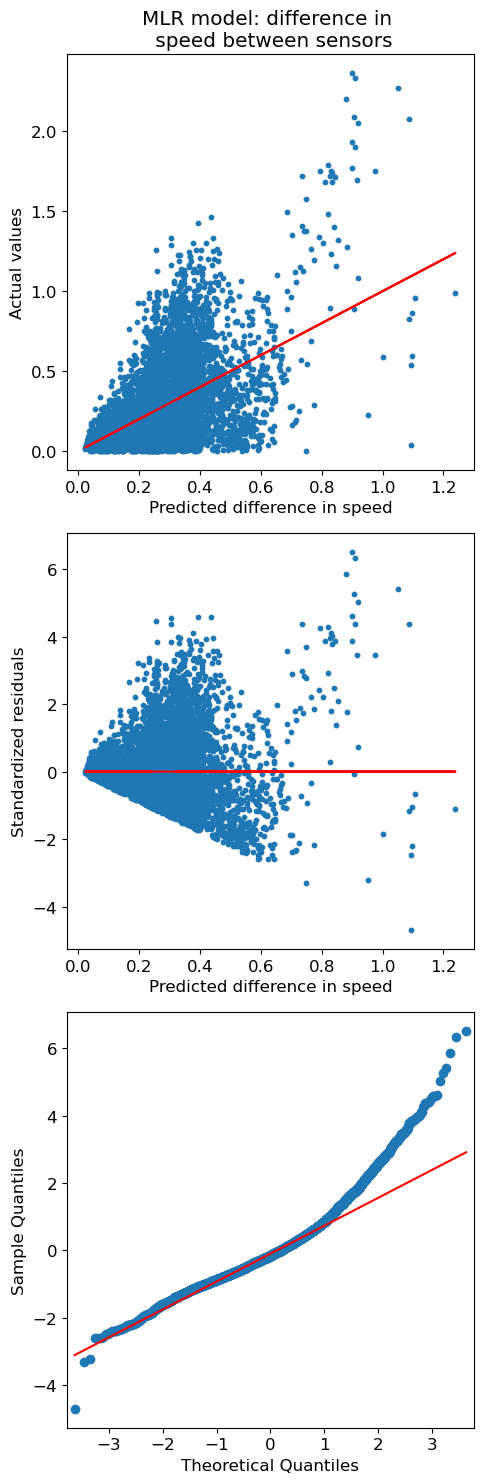

In [32]:
mod = smf.gls(formula='speed_diff_abs ~ speed_avg*environment +control_S2_100*environment+distance*environment', data=alldf)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alldf.group})
#print(res.summary())


fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15), layout='tight')

slope, intercept = np.polyfit(res.fittedvalues, alldf.speed_diff_abs,1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('MLR model: difference in \n speed between sensors')
ax[0].scatter(res.fittedvalues, alldf.speed_diff_abs, s=10, rasterized=True)
ax[0].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[0].set_xlabel ('Predicted difference in speed')
ax[0].set_ylabel ('Actual values')


slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10, rasterized=True)
ax[1].plot(res.fittedvalues, abline_values, 'r', rasterized=True )
ax[1].set_xlabel ('Predicted difference in speed')
ax[1].set_ylabel ('Standardized residuals')

sm.qqplot(res.resid_pearson, line='q', ax=ax[2], rasterized=True)

plt.show()

fig.savefig('residuals_speed_spatial_S5b.svg', dpi=600, format='svg')